  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 4112
     njev: 12
      nlu: 590
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 3.33444481e-02, 6.66888963e-02, ...,
       9.99333111e+01, 9.99666556e+01, 1.00000000e+02])
 t_events: [array([0.])]
        y: array([[ 2.00000000e-01,  2.00058208e-01,  2.00232824e-01, ...,
         3.81188755e+00,  3.76608063e+00,  3.71994612e+00],
       [ 0.00000000e+00,  3.49129646e-03,  6.98202772e-03, ...,
        -1.36862495e+00, -1.37877993e+00, -1.38827624e+00],
       [ 4.00000000e-01,  3.98815556e-01,  3.95275290e-01, ...,
         3.56057237e+00,  3.52621141e+00,  3.49280267e+00],
       [ 0.00000000e+00, -7.09775583e-02, -1.41165561e-01, ...,
        -1.04503254e+00, -1.01593069e+00, -9.87893210e-01]])
 y_events: [array([[0.2, 0. , 0.4, 0. ]])]


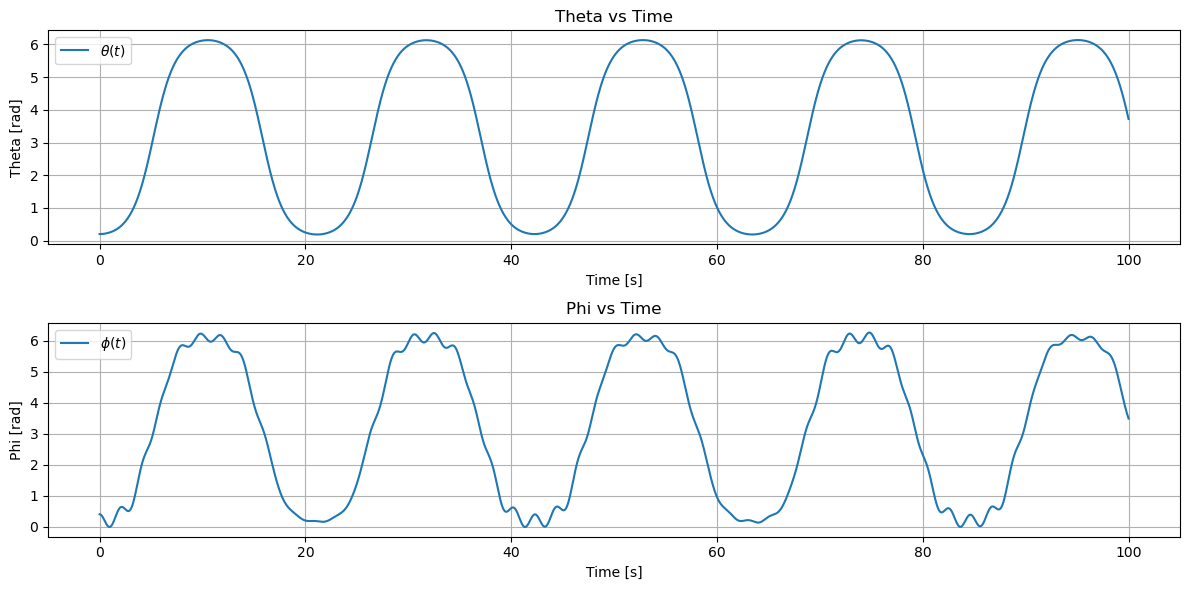

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


g = 9.81
l = 1
gamma = 0.02
beta = 0.005

theta_0 = 0.2
theta_dot_0 = 0
phi_0 = 0.4
phi_dot_0 = 0

variable_list_0 = [theta_0, theta_dot_0, phi_0, phi_dot_0]


def equations(t, variable_list):

    theta, theta_dot, phi, phi_dot = variable_list

    matrix_A = np.array([[1+2*beta*(1-np.cos(phi)), -beta*(1-np.cos(phi))],
                         [beta*(1-np.cos(phi)),     -beta                ]])
    
    vector_B = np.array([-beta*np.sin(phi)*(phi_dot**2-2*theta_dot*phi_dot),
                         beta*theta_dot**2*np.sin(phi)                     ])
                         
    vector_C = np.array([beta*g/l*(np.sin(theta-phi-gamma)-np.sin(theta-gamma)-g/l*np.sin(theta-gamma)),
                         beta*g/l*np.sin(theta-phi-gamma)])

    theta_ddot, phi_ddot = np.linalg.solve(matrix_A, -vector_B-vector_C)
    
    return [theta_dot, theta_ddot, phi_dot, phi_ddot]


def heelstrike_event_and_change_defination(variable_list):

     theta, theta_dot, phi, phi_dot = variable_list

     matrix_Change = np.array([[-1, 0,                                   0, 0],
                               [0,  np.cos(2*theta),                     0, 0],
                               [-2,  0,                                  0, 0],
                               [0,  np.cos(2*theta)*(1-np.cos(2*theta)), 0, 0]])
     
     variable_matrix = np.array([[theta],
                                 [theta_dot],
                                 [phi],
                                 [phi_dot]])    

     result_matrix = np.dot(matrix_Change, variable_matrix)

     theta_new = result_matrix[0, 0]
     theta_dot_new = result_matrix[1, 0]
     phi_new = result_matrix[2, 0]
     phi_dot_new = result_matrix[3, 0]

     return [theta_new, theta_dot_new, phi_new, phi_dot_new]


def monitor(t, variable_list):

    theta, theta_dot, phi, phi_dot = variable_list

    return phi - 2*theta


t_span = [0, 100]
t_eval = np.linspace(*t_span, 3000)
solution_list = []
current_t0 = t_span[0]

times = np.array([])
thetas = np.array([])
phis = np.array([])

max_points = 50
points_collected = 0

while current_t0 < t_span[1] and points_collected < max_points:

    t_eval = np.linspace(current_t0, t_span[1], 3000)

    sol = solve_ivp(equations, [current_t0, t_span[1]], variable_list_0, method='Radau', t_eval=t_eval, events=monitor)
    
    print(sol)

    solution_list.append(sol)

    if len(sol.t_events[0]) > 0:
        current_t0 = sol.t_events[0][0]
        variable_list_0 = heelstrike_event_and_change_defination(sol.y[:, -1])
        theta_0, theta_dot_0, phi_0, phi_dot_0 = variable_list_0

        points_collected += len(sol.t)

        times = np.concatenate((times, sol.t))
        thetas = np.concatenate((thetas, sol.y[0]))
        phis = np.concatenate((phis, sol.y[2]))

        if len(times) >= max_points:
            break

    else:
        break


plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(times, thetas, label=r'$\theta(t)$')
plt.title('Theta vs Time')
plt.xlabel('Time [s]')
plt.ylabel('Theta [rad]')
plt.grid(True)
plt.legend()

"""
for sol in solution_list:
    for t_event in sol.t_events[0]:
        plt.plot(t_event, np.interp(t_event, times, thetas), 'ro', markersize=10)
"""


plt.subplot(2, 1, 2)
plt.plot(times, phis, label=r'$\phi(t)$')
plt.title('Phi vs Time')
plt.xlabel('Time [s]')
plt.ylabel('Phi [rad]')
plt.grid(True)
plt.legend()

"""
for sol in solution_list:
    for t_event in sol.t_events[0]:
        plt.plot(t_event, np.interp(t_event, times, phis), 'ro', markersize=10)
"""

plt.tight_layout()
plt.show()
